<a href="https://colab.research.google.com/github/Pranav-2509/NIGHT_VISION_SELF/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#To Load The Dataset

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import argparse
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [ ]:
!pip install hdf5storage
import hdf5storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/My Drive/2d


/content/gdrive/My Drive/2d


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed (42)

In [ ]:
class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')

    if os.path.isdir(data_path):
        return path
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)

path='/content/gdrive/My Drive/2d/'
parser = argparse.ArgumentParser()
parser.add_argument('path', help='path to the brain_tumor_dataset directory', type=dir_path)
parser.add_argument('--image-dimension', '-d', default=512, help='dimension of the image', type=int)
args = parser.parse_args(args=[path])

labels = []
images = []
masks = []

data_dir = os.path.join(args.path, 'data').replace('\\', '/')
files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(args.image_dimension, args.image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(args.image_dimension, args.image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(args.path, 'labels.npy'), labels)
np.save(os.path.join(args.path, 'images.npy'), images)
np.save(os.path.join(args.path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', args.path)

<ipython-input-7-61c29a2fcbfc>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(mat_file[0]))


[530/3074] images loaded: 17.2 %

KeyboardInterrupt: 

In [ ]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)

(3074,)
(3074, 512, 512)
(3074, 512, 512)


#Deleting some Images

In [ ]:
images_short = images[:1500]
del images

masks_short = masks[:1500]
del masks

labels_short = labels[:1500]
del labels

[1430 1400  515]


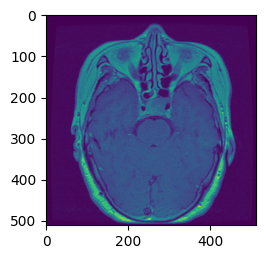

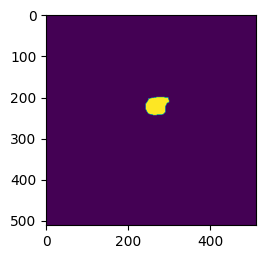

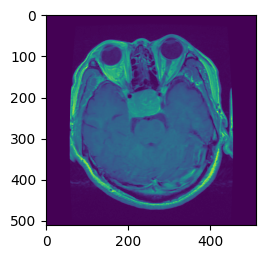

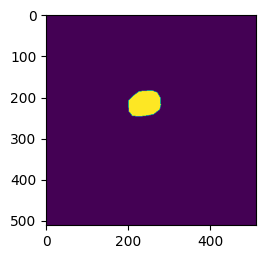

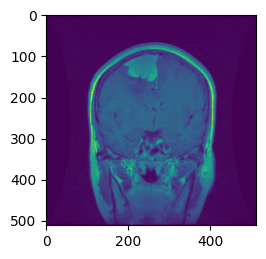

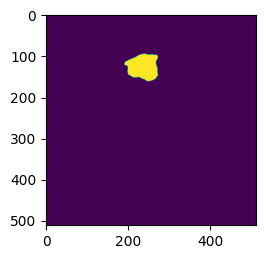

In [ ]:
# Data Exploration

random_indices = np.random.randint(0, images_short.shape[0], 3)

print (random_indices)

for i in range (len(random_indices)*2):
  plt.figure (figsize = (10, 6))
  y = i//2
  if (i%2==0):
    plt.subplot(2, 3, i+1)
    plt.imshow(images_short[random_indices[y]], cmap = 'viridis')
  else :
    plt.subplot(2, 3, i+1)
    plt.imshow(masks_short[random_indices[y]], cmap = 'viridis')

#To Resize Images

In [ ]:
import cv2

def resize_image (img, size):
  resized_image = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
  return resized_image

In [ ]:
resized_images = []

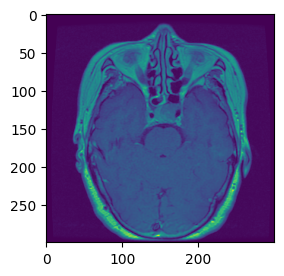

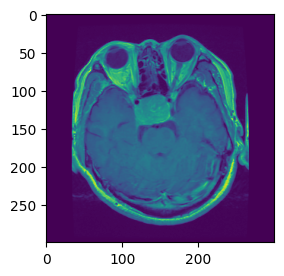

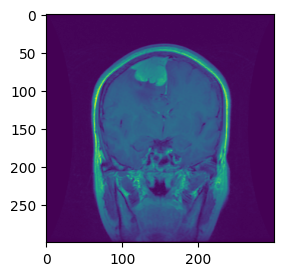

In [ ]:
for img in images_short:
  new_image = resize_image(img, (300, 300))
  resized_images.append(new_image)

del images_short

cols = 1

for i in random_indices:
  plt.figure (figsize = (10, 6))
  plt.subplot(1, 3, cols)
  plt.imshow(resized_images[i], cmap = 'viridis')
  cols+=1

#Resizing the ideal segmentation masks

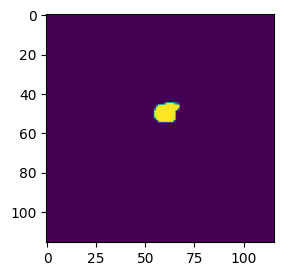

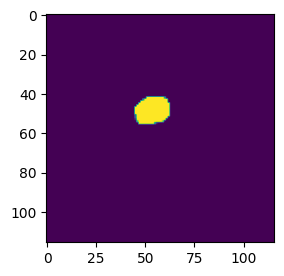

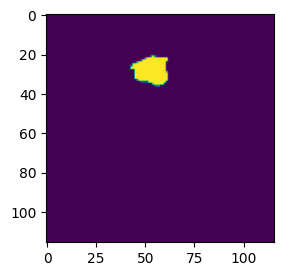

In [ ]:
resized_seg_masks = []

masks_short = masks_short.astype('float32')

for mask in masks_short:
  new_mask = resize_image(mask, (116, 116))
  resized_seg_masks.append(new_mask)

del masks_short

cols = 1

for i in random_indices:
  plt.figure (figsize = (10, 6))
  plt.subplot(1, 3, cols)
  plt.imshow(resized_seg_masks[i], cmap = 'viridis')
  cols+=1

In [ ]:
#Converting the resized masks and images into numpy arrays

resized_seg_masks = np.array(resized_seg_masks)
resized_images = np.array(resized_images)

print(resized_seg_masks.shape)
print(resized_images.shape)

(1500, 116, 116)
(1500, 300, 300)


#Normalising the Images

In [ ]:
import numpy as np

In [ ]:
scaler = StandardScaler()

for i in range (len(resized_images)):
  np_resized_image = (resized_images[i]).numpy()
  scaled_array = scaler.fit_transform(np_resized_image)
  resized_images[i] = scaled_array


#Building the Unet

In [ ]:
#Imports
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3),
      nn.ReLU(inplace=True)
  )
  return conv

In [ ]:
def crop_image(img, size):
  _, _, height, width = img.shape
  delta = (height-size)//2
  return img[:, :, delta:height-delta, delta:width-delta]

#Model

In [ ]:
#To see how concat works

# x = torch.randn(10, 1, 300, 300)
# y = torch.randn(10, 1, 300, 300)
# z = torch.cat([x, y], dim = 0)
# print (z.shape)

In [ ]:
class UNet(nn.Module):
  def __init__(self):
        super().__init__()
        self.maxpool_conv = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = double_conv(1, 32)

        self.down_conv_2 = double_conv(32, 64)

        self.down_conv_3 = double_conv(64, 128)

        self.down_conv_4 = double_conv(128, 256)

        self.down_conv_5 = double_conv(256, 512)

        self.down_conv_6 = double_conv(512, 256)

        self.down_conv_7 = double_conv(256, 128)

        self.down_conv_8 = double_conv(128, 64)

        self.down_conv_9 = double_conv(64, 32)

        self.down_conv_10 = nn.Conv2d(32, 1, kernel_size=1)

        self.up_conv_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

        self.up_conv_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.up_conv_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        self.up_conv_4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

  def forward (self, image):
    x1 = self.down_conv_1(image)

    x2 = self.maxpool_conv(x1)
    x2 = self.down_conv_2(x2)

    x3 = self.maxpool_conv(x2)
    x3 = self.down_conv_3(x3)

    x4 = self.maxpool_conv(x3)
    x4 = self.down_conv_4(x4)

    x5 = self.maxpool_conv(x4)
    x5 = self.down_conv_5(x5)

    x5 = self.up_conv_1(x5)
    x4 = crop_image(x4, x5.shape[2])
    x5 = torch.cat([x5, x4], dim=1)
    x5 = self.down_conv_6(x5)

    x5 = self.up_conv_2(x5)
    x3 = crop_image(x3, x5.shape[2])
    x5 = torch.cat([x5, x3], dim=1)
    x5 = self.down_conv_7(x5)

    x5 = self.up_conv_3(x5)
    x2 = crop_image(x2, x5.shape[2])
    x5 = torch.cat([x5, x2], dim=1)
    x5 = self.down_conv_8(x5)

    x5 = self.up_conv_4(x5)
    x1 = crop_image(x1, x5.shape[2])
    x5 = torch.cat([x5, x1], dim=1)
    x5 = self.down_conv_9(x5)

    x5 = self.down_conv_10(x5)
    x5 = x5.flatten()
    x5 = torch.sigmoid(x5)
    return (x5)
    # return (x5)

#To test the Forward pass

In [ ]:
# i = double_conv(1, 64)
# print (i(img).shape)

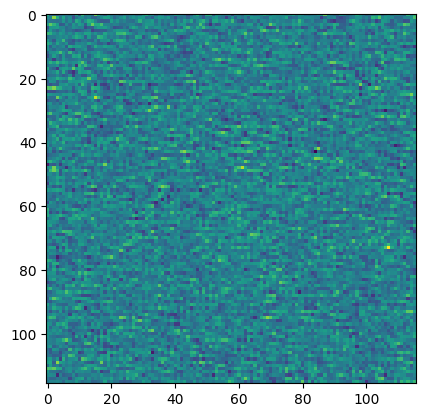

In [ ]:
img = torch.randn(1, 1, 300, 300)
model = UNet()
out = model(img)
out = out.cpu().detach().numpy()
plt.imshow(out.reshape(116, 116))

In [ ]:
# x = torch.randn(10, 1, 572, 572)
# y = model(x)
# print(y.shape)

#Dataloader Creation

In [ ]:
resized_images = torch.tensor(resized_images.astype(np.float32))

In [ ]:
resized_images = resized_images.unsqueeze(dim = 1)

In [ ]:
print (resized_images.shape)

torch.Size([1500, 1, 300, 300])


In [ ]:
train_dataloader = DataLoader(dataset=resized_images,
                              batch_size=1,
                              num_workers=1,
                              shuffle=False)


checking the size of each batch

In [ ]:
for index, data in enumerate (train_dataloader):
  print (data.shape)
  break

torch.Size([1, 1, 300, 300])


#Device agnostic code

In [ ]:
model = UNet().to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
resized_seg_masks = (torch.tensor(resized_seg_masks)).float()

In [ ]:
#Training Function:

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0

    # Loop through data loader data batches
    for batch, (X) in enumerate(dataloader):
        if (batch%100 == 0):
          print (f"Batches done : {batch}")
        # Send data to target device
        X = X.to(device)
        y = resized_seg_masks[batch]
        y = y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # Flatten the resized ideal seg mask
        y = y.flatten()

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()



    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    return train_loss

In [ ]:
train_loss = train_step(model, train_dataloader, criterion, optimizer)
print (train_loss)

Batches done : 0


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Batches done : 100
Batches done : 200
Batches done : 300
Batches done : 400
Batches done : 500
Batches done : 600
Batches done : 700
Batches done : 800
Batches done : 900
Batches done : 1000
Batches done : 1100
Batches done : 1200
Batches done : 1300
Batches done : 1400
0.09621275036223233


#Testing if predictions are correct

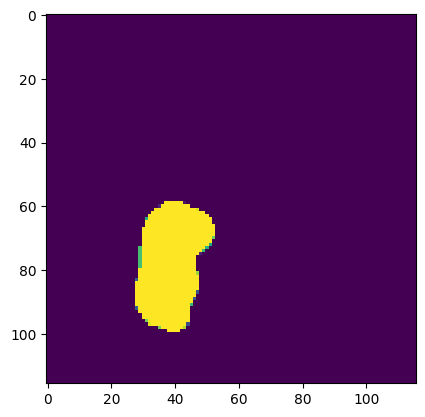

In [ ]:
mask = resized_seg_masks[100]
plt.imshow(mask)

In [ ]:
predicted_seg_mask = model((resized_images[100].unsqueeze(dim = 0)).to(device))

In [ ]:
predicted_seg_mask = predicted_seg_mask.reshape (116, 116)

In [ ]:
predicted_seg_mask = predicted_seg_mask.cpu().detach().numpy()

In [ ]:
print (predicted_seg_mask.min())

0.013959123


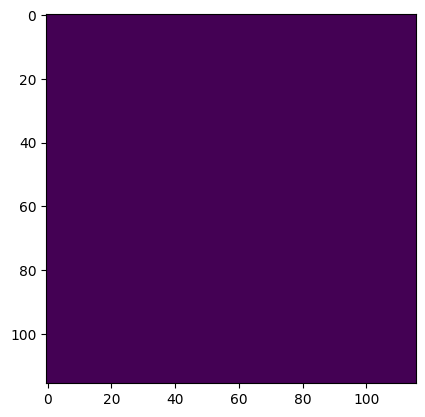

In [ ]:
plt.imshow(np.round(predicted_seg_mask))

In [ ]:
criterion = nn.BCELoss()
y_pred = torch.tensor([0]).float()
y_real = torch.tensor([1]).float()
loss = criterion(y_pred, y_real)
print (loss)

tensor(100.)
